In [1]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
import findspark
findspark.init()

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StringType

from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

In [5]:
spark = SparkSession .builder \
  .master("local[*]")\
  .appName("amazon")\
  .config("spark.memory.fraction", 0.8)\
  .config("spark.executor.memory", "10g")\
  .config("spark.driver.memory", "10g")\
  .config("spark.sql.shuffle.partitions" , "800")\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","10g")\
  .getOrCreate()

In [6]:
reviews = pd.read_csv('../../Data/ratings_Office_Products.csv',header=None)

In [7]:
reviews.rename(columns={reviews.columns[0]: 'reviewerId',
                        reviews.columns[1]: 'asin',
                        reviews.columns[2]: 'overall',
                        reviews.columns[3]: 'unixReviewTime'}, inplace=True)

In [8]:
reviews.head(5)

,reviewerId,asin,overall,unixReviewTime
0,A2UESEUCI73CBO,0078800242,5.0,1374192000
1,A3BBNK2R5TUYGV,0113000316,5.0,1359417600
2,A5J78T14FJ5DU,0113000316,3.0,1318723200
3,A2P462UH5L6T57,043928631X,5.0,1356912000
4,A2E0X1MWNRTQF4,0439340039,1.0,1379721600


<AxesSubplot:>

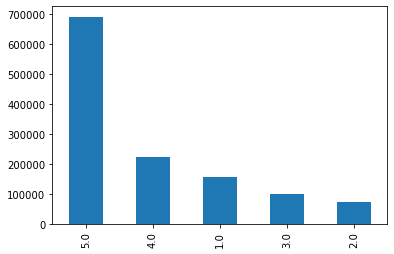

In [9]:
reviews['overall'].value_counts().plot.bar()

### Phần lớn review là 5*

In [10]:
users = reviews.reviewerId.nunique()
products = reviews.asin.nunique()
numberator = reviews.overall.count()

In [11]:
print("Number of unique reviewer:", users)
print("Number of unique products:", products)
print("Number of unique review:", numberator)

Number of unique reviewer: 909314
Number of unique products: 130006
Number of unique review: 1243186


In [12]:
# Number of rating matrix could contain if no empy cells
denominator = users * products
denominator

118216275884

In [13]:
# Calculating sparsity
sparsity = 1 - (numberator * 1.0 / denominator)
print("Sparsity:", sparsity)

Sparsity: 0.9999894838000039


In [14]:
data = spark.createDataFrame(reviews[['reviewerId', 'asin', 'overall']])

In [15]:
data.show(5)

+--------------+----------+-------+
|    reviewerId|      asin|overall|
+--------------+----------+-------+
|A2UESEUCI73CBO|0078800242|    5.0|
|A3BBNK2R5TUYGV|0113000316|    5.0|
| A5J78T14FJ5DU|0113000316|    3.0|
|A2P462UH5L6T57|043928631X|    5.0|
|A2E0X1MWNRTQF4|0439340039|    1.0|
+--------------+----------+-------+
only showing top 5 rows



In [16]:
# Create an indexer
indexer = StringIndexer(inputCol='asin', outputCol='asin_idx')
# Indexer identifies categories in the data
indexer_model = indexer.fit(data)
# Indexer create a new column with numeric index values
data_indexed = indexer_model.transform(data)

In [17]:
# Repeat the process for the other categorical feature
indexer1 = StringIndexer(inputCol='reviewerId', outputCol='reviewerId_idx')
indexer1_model = indexer1.fit(data)
data_indexed = indexer1_model.transform(data_indexed)

In [18]:
data_indexed.show(5, truncate=True)

+--------------+----------+-------+--------+--------------+
|    reviewerId|      asin|overall|asin_idx|reviewerId_idx|
+--------------+----------+-------+--------+--------------+
|A2UESEUCI73CBO|0078800242|    5.0| 71702.0|      112059.0|
|A3BBNK2R5TUYGV|0113000316|    5.0| 51103.0|      621354.0|
| A5J78T14FJ5DU|0113000316|    3.0| 51103.0|       26236.0|
|A2P462UH5L6T57|043928631X|    5.0| 71703.0|      500720.0|
|A2E0X1MWNRTQF4|0439340039|    1.0| 71704.0|      440389.0|
+--------------+----------+-------+--------+--------------+
only showing top 5 rows



In [19]:
training, test = data_indexed.randomSplit([0.7, 0.3])

In [20]:
als = ALS(maxIter=5, regParam=0.09, rank=25,
          userCol="reviewerId_idx", itemCol="asin_idx", ratingCol="overall",
          coldStartStrategy="drop", nonnegative=True)
model = als.fit(training)

In [21]:
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)

In [22]:
predictions.select(["asin_idx", "reviewerId_idx", "overall", "prediction"]).show(5)

+--------+--------------+-------+----------+
|asin_idx|reviewerId_idx|overall|prediction|
+--------+--------------+-------+----------+
|  1580.0|       20147.0|    5.0| 2.6504235|
|  1580.0|       35533.0|    5.0| 1.6771224|
|  1580.0|       22182.0|    5.0| 1.7683247|
|  1580.0|       59223.0|    5.0|  3.437498|
|  1580.0|       16896.0|    4.0|  5.971655|
+--------+--------------+-------+----------+
only showing top 5 rows



In [23]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="overall", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root mean squared error =", str(rmse))

Root mean squared error = 2.270532020346771


In [24]:
users = ['A00473363TJ8YSZ3YAGG9', 'A335QXPTV1RIV1', 'ATIMW8SYGAASW']

In [25]:
datasets = data_indexed.filter(data_indexed.reviewerId.isin(users)).select('reviewerId_idx').distinct()

In [26]:
user_recs = model.recommendForUserSubset(datasets, 3)

In [27]:
result = user_recs.toPandas()

In [31]:
result

,reviewerId_idx,recommendations
0,2602,"[(44515, 11.386368751525879), (90713, 10.82167..."
1,2132,"[(25690, 7.283169269561768), (66088, 7.2365217..."
2,10981,"[(54566, 9.222907066345215), (16581, 8.7635574..."


In [39]:
nrecs = result['recommendations'].apply(pd.Series).merge(result, right_index=True, left_index=True).drop(["recommendations"], axis=1).melt(id_vars=["reviewerId_idx"], value_name="recommendation").drop(["variable"], axis=1).dropna()
nrecs = nrecs.sort_values('reviewerId_idx')
nrecs = pd.concat([nrecs["recommendation"].apply(pd.Series),
                   nrecs["reviewerId_idx"]], axis=1)
nrecs.columns = ['ProductID_index', 'Rating', 'UserID_index']

In [40]:
nrecs

,ProductID_index,Rating,UserID_index
1,25690.0,7.283169,2132
4,66088.0,7.236522,2132
7,103794.0,7.167532,2132
0,44515.0,11.386369,2602
3,90713.0,10.821674,2602
6,28562.0,10.690786,2602
2,54566.0,9.222907,10981
5,16581.0,8.763557,10981
8,21573.0,8.707150,10981
